In [50]:
import requests
import shutil

import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from PIL import Image

In [51]:
model = torch.load('./saves/best_model.pt', map_location='cpu')

In [52]:
img_url = "https://luckysbb.com/wp-content/uploads/2017/02/new_puppy.jpg"
filename = "./data/img.jpg"

In [53]:
def download_img(img_url, filename):
    r = requests.get(img_url, stream=True)
    if r.status_code == 200:
        r.raw.decode_content = True
        with open(filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
        
        return True

    else:
        return False

In [54]:
download_img(img_url, filename)

True

In [55]:
image = Image.open(filename).convert('RGB')

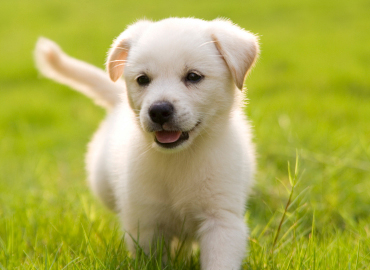

In [56]:
image

In [57]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [58]:
image_tensor = transform(image)
image_batch = image_tensor.unsqueeze(0)

In [59]:
model.eval();

In [60]:
with torch.no_grad():
    out = model(image_batch)

In [61]:
predicted_mask = torch.round(out.sigmoid().squeeze(0))
predicted_mask = F.resize(predicted_mask, size=[image.size[1], image.size[0]],
                          interpolation=InterpolationMode.NEAREST)

In [62]:
out_array = predicted_mask.data.numpy()

In [63]:
out_array_rgb = np.transpose(
    np.concatenate(
        [out_array,
         np.zeros_like(out_array),
         np.zeros_like(out_array)]), [1, 2, 0])


In [64]:
mask_pil = Image.fromarray(np.uint8(out_array_rgb * 255))

In [65]:
result = Image.blend(image, mask_pil, 0.4)

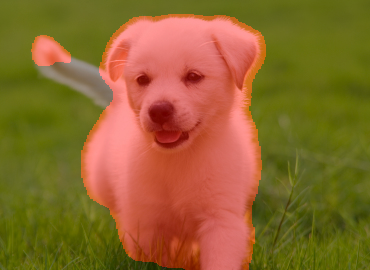

In [66]:
result